In [26]:
from src.utils.preprocessing import *
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import torchaudio.transforms as tat

In [27]:
import matplotlib.pyplot as plt

raw_pcg_signals, labels = get_pcg_data('../sample_train')
resampled_pcg_signals = resample_pcg_signals(raw_pcg_signals)
filtered_signals = apply_bandpass_filter(resampled_pcg_signals,low_cutoff=1, high_cutoff=200)

# for i in range(5,20):
#     plt.rcParams["figure.figsize"] = (20,3)
#     plt.plot(resampled_pcg_signals[i][0][0][5000:10000])
#     plt.show()
#     plt.plot(filtered_signals[i][0][0][5000:10000])
#     print(i,labels[i])
#     plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
mel_spectrogram_transform = tat.MelSpectrogram(1000)

In [ ]:
x = signals[0][0][0]

In [ ]:
x = torch.from_numpy(x.copy()).type(torch.FloatTensor)

In [ ]:
mel_spects = mel_spectrogram_transform()

In [ ]:
mel_spects.shape

In [ ]:
torch.cuda.is_available()

In [ ]:
raw_pcg_signals, labels, pids = get_pcg_data('../sample_train')
resampled_pcg_signals = resample_pcg_signals(raw_pcg_signals)
filtered_signals = apply_bandpass_filter(resampled_pcg_signals,low_cutoff=1, high_cutoff=200)

In [ ]:
n_fft = 1024
win_length = None
hop_length = 500
n_mels = 512
n_mfcc = 256

mfcc_transform = tat.MFCC(
    sample_rate=1000,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

In [ ]:
x = mfcc_transform(torch.from_numpy(filtered_signals[0][0][3].copy()).type(torch.FloatTensor))

In [ ]:
x[0]

In [ ]:
x.shape

In [ ]:
signals, labels, pids = get_pcg_data("../sample_train")
signals = resample_pcg_signals(signals)
signals = apply_bandpass_filter(signals, low_cutoff=1, high_cutoff=200)
signals = split_signals(signals, final_len=8192, stride=2048)

mel_spects = make_mel_spectrograms(signals, 1000)

In [ ]:
torch.stack(mel_spects[0][0]).shape

In [ ]:
len(mel_spects[0][0]), type(mel_spects[0][0]), type(mel_spects[0][0][0])

In [38]:
from src.utils.preprocessing import *
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import librosa
import torchaudio.transforms as tat

In [39]:
class PCGDataset_(Dataset):
    def __init__(self, data_folder, transform=None):
        self.transform  = transform
        self.signals    = list()
        self.labels     = list()
        self.idxs       = list()
        self.mel_spects = list()
        self.tp = np.array([0,0,0])
        signals, labels, pids = get_pcg_data(data_folder)
        # signals = resample_pcg_signals(signals)
        # signals = apply_bandpass_filter(signals, low_cutoff=1, high_cutoff=200)
        signals = split_signals(signals, final_len=40000, stride=8000)
        
        mel_spects = make_mel_spectrograms(signals, 4000)
        
        for patient_no in range(len(signals)):
            for signal_no in range(len(signals[patient_no][0])):
                self.signals.append(signals[patient_no][0][signal_no])
                self.mel_spects.append(mel_spects[patient_no][0][signal_no])
                self.labels.append(labels[patient_no])
                self.idxs.append(pids[patient_no])
                # print(labels[patient_no], type(labels[patient_no]))
                self.tp = np.add(self.tp,labels[patient_no])
                
                if labels[patient_no][0] == 1:
                    self.signals.append(signals[patient_no][0][signal_no])
                    self.mel_spects.append(mel_spects[patient_no][0][signal_no])
                    self.labels.append(labels[patient_no])
                    self.idxs.append(pids[patient_no])
                    self.tp = np.add(self.tp,labels[patient_no])
                    
                    self.signals.append(signals[patient_no][0][signal_no])
                    self.mel_spects.append(mel_spects[patient_no][0][signal_no])
                    self.labels.append(labels[patient_no])
                    self.idxs.append(pids[patient_no])
                    self.tp = np.add(self.tp,labels[patient_no])
        
        print(self.tp, "hehe", self.mel_spects[3].max())
        
        
    def mel_shape(self):
        return self.mel_spects.shape
        
    def __getitem__(self, index):
        signal, mel_spect, label, pid = self.signals[index], self.mel_spects[index], self.labels[index], self.idxs[index]
        signal = signal.reshape(1,signal.shape[0])
        if self.transform:
            signal, label = self.transform(signal.copy()), self.transform(label)
            signal, label = signal.type(torch.FloatTensor), label.type(torch.FloatTensor)
        return signal, mel_spect, label, pid
        
    def __len__(self):
        return len(self.signals)

In [40]:
class PCGDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.transform  = transform
        self.signals    = list()
        self.labels     = list()
        self.idxs       = list()
        self.mel_spects = list()
        
        signals, labels, pids = get_pcg_data(data_folder)
        # signals = resample_pcg_signals(signals)
        # signals = apply_bandpass_filter(signals, low_cutoff=1, high_cutoff=200)
        signals = split_signals(signals, final_len=40000, stride=8000)
        
        mel_spects = make_mel_spectrograms(signals, 4000)
        
        for patient_no in range(len(signals)):
            for signal_no in range(len(signals[patient_no][0])):
                self.signals.append(signals[patient_no][0][signal_no])
                self.mel_spects.append(mel_spects[patient_no][0][signal_no])
                self.labels.append(labels[patient_no])
                self.idxs.append(pids[patient_no])
        
    def mel_shape(self):
        return self.mel_spects.shape
        
    def __getitem__(self, index):
        signal, mel_spect, label, pid = self.signals[index], self.mel_spects[index], self.labels[index], self.idxs[index]
        signal = signal.reshape(1,signal.shape[0])
        if self.transform:
            signal, label = self.transform(signal.copy()), self.transform(label)
            signal, label = signal.type(torch.FloatTensor), label.type(torch.FloatTensor)
        return signal, mel_spect, label, pid
        
    def __len__(self):
        return len(self.signals)

In [41]:
trainset = PCGDataset('../sample_train', transform=torch.from_numpy)
testset  = PCGDataset('../sample_test', transform=torch.from_numpy)

In [42]:
x = trainset.__getitem__(1)[1]
x = x/x.max()
x.shape

torch.Size([64, 201])

In [43]:
trainloader = DataLoader(dataset=trainset, batch_size=16, shuffle=False)
testloader  = DataLoader(dataset=testset, batch_size=16, shuffle=False)

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
device

device(type='cuda')

In [46]:
# arch_config = {
# 'n_input_channels':1,
# 'signal_length':8192,
# 'net_filter_size':[16   , 32 , 64  , 128, 196, 256],
# 'net_signal_length':[8192, 4096, 1024, 256,  64,  16],
# 'kernel_size':51,
# 'n_classes':3,
# 'dropout_rate':0.3
# }

In [80]:
train_config = {
'num_epochs':3,
'learning_rate':5e-3,
}

In [81]:
# wandb.init(project="PCG", entity="zelda", config={**arch_config, **train_config})

In [82]:
# arch_config = {
# 'n_input_channels':1,
# 'signal_length':8192,
# 'net_filter_size':[8   , 16  , 32],
# 'net_signal_length':[1024, 256, 64],
# 'kernel_size':51,
# 'n_classes':3,
# 'dropout_rate':0.1
# }

# model = ResNet1d(input_dim=(arch_config['n_input_channels'], arch_config['signal_length']), 
#          blocks_dim=list(zip(arch_config['net_filter_size'], arch_config['net_signal_length'])),
#          kernel_size=arch_config['kernel_size'],
#          n_classes=arch_config['n_classes'],
#          dropout_rate=arch_config['dropout_rate'])

In [50]:
from src.models.ast_models import ASTModel

In [51]:
model = ASTModel(label_dim=3,input_fdim=201, input_tdim=64, imagenet_pretrain=False)

---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
frequncey stride=10, time stride=10
number of patches=95


In [52]:
model = model.to(device)

In [83]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'])
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['learning_rate'], weight_decay=0.001)

In [54]:
import matplotlib.pyplot as plt
import librosa

In [56]:
x = trainset.__getitem__(456)[1]
x = x/x.max()
# plot_spectrogram(x)

In [57]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [97]:
val_loss =[]
train_loss = []
best_loss = 1000
curr_loss = 1000

for epoch in (range(train_config['num_epochs'])):
    
    model.train()
    t = [] 
    for i, (inputs, specs, labels, pid) in tqdm(enumerate(trainloader), total=len(trainloader), leave=False):
        
        # inputs = torch.rand([64, 128, 33]).to(device)
        inputs = specs.to(device)
        labels = labels.to(device)
        # print(specs.shape)
        # plot_spectrogram(specs[0])
        
        outputs = model(inputs)
        loss   = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        t.append(np.array(loss.detach().cpu()).item())
    
    train_loss.append(np.array(t).mean())
    print(train_loss[-1])

    model.eval()
    l=[]
    for i, (inputs, specs, labels, pid) in tqdm(enumerate(testloader), total=len(testloader), leave=False):
        
        inputs = specs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss   = criterion(outputs, labels)
        l.append(np.array(loss.detach().cpu()).item())
        # wandb.log({'test_loss':loss})
    val_loss.append(np.array(l).mean())
    
    print('Epoch ',epoch ,' train loss: ', np.array(t).mean(), ' val loss: ', np.array(l).mean())
    # break
    curr_loss = np.array(l).mean()
    if curr_loss < best_loss :
        # torch.save(model, 'models/best_model'+str(curr_loss)+'.pt')
        best_loss = curr_loss
        

  0%|          | 0/956 [00:00<?, ?it/s]

0.7214437481249726


  0%|          | 0/417 [00:00<?, ?it/s]

Epoch  0  train loss:  0.7214437481249726  val loss:  0.8333890352407091


  0%|          | 0/956 [00:00<?, ?it/s]

0.7158698063016437


  0%|          | 0/417 [00:00<?, ?it/s]

Epoch  1  train loss:  0.7158698063016437  val loss:  0.6691035356024186


  0%|          | 0/956 [00:00<?, ?it/s]

0.6799990387719171


  0%|          | 0/417 [00:00<?, ?it/s]

Epoch  2  train loss:  0.6799990387719171  val loss:  0.829682082589939


In [85]:
len(testset)

6663

In [86]:
val_loss

[0.8541040946628978, 0.8562909773588895, 0.8546734176468935]

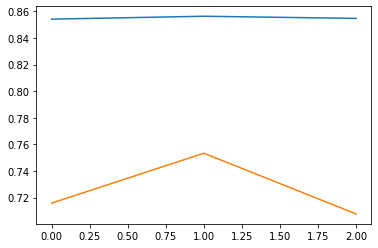

In [87]:
import matplotlib.pyplot as plt
plt.plot(np.array(val_loss))
plt.plot(np.array(train_loss))

In [88]:
true= []
preds = []
patient_labels = {}
patient_preds = {}
model.eval()
for i, (inputs, specs, labels, pids) in tqdm(enumerate(testloader), total=len(testloader), leave=False):
    inputs = specs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    # print(outputs)
    # print(outputs.shape, labels.shape)
    a =np.array(outputs.detach().cpu())
    b= np.array(labels.detach().cpu())
    true = np.concatenate((true, np.argmax(b, axis = 1)))
    preds = np.concatenate((preds, np.argmax(a, axis = 1)))
    tt = np.argmax(b, axis = 1)
    pp = np.argmax(a, axis = 1)
    
    # print("dsf",len(pp))
    # print("ffd",len(tt))
    
    for i in range(len(tt)):
        patient_labels[pids[i]] = tt[i]
        try:
            if patient_preds[pids[i]]:
                patient_preds[pids[i]].append(pp[i]) 
        except:
            patient_preds[pids[i]] = [pp[i]]
        
        
    # print(a, np.argmax(a, axis = 1))

  0%|          | 0/417 [00:00<?, ?it/s]

In [89]:
results = {}
for i in patient_preds:
    ls = patient_preds[i]
    probs = np.array([ls.count(0), ls.count(1), ls.count(2)])/len(ls)
    val = probs.max()
    pos = np.where( probs == val)
    results[i] = { 'prediction':pos[0][0], 'confidence':val}

In [90]:
print("acc",np.sum(true== preds, dtype=float)/len(true))

acc 0.7715743659012457


(array([1253.,    0.,    0.,    0.,    0.,  269.,    0.,    0.,    0.,
        5141.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

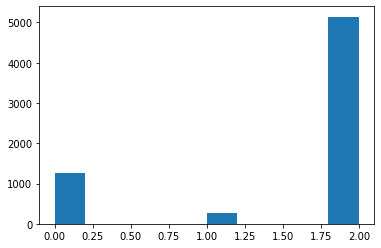

In [91]:
plt.hist(true)

(array([   0.,    0.,    0.,    0.,    0., 6663.,    0.,    0.,    0.,
           0.]),
 array([1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5]),
 <BarContainer object of 10 artists>)

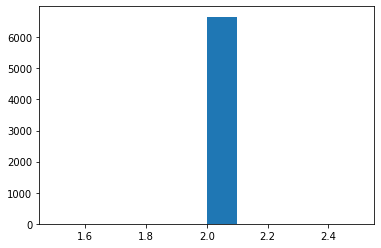

In [92]:
plt.hist(preds)

In [93]:
true

array([2., 2., 2., ..., 2., 2., 2.])

In [94]:
cm = np.array([0]*9).reshape(3,3)

In [95]:
for i in range(len(true)):
    cm[int(true[i])][int(preds[i])] += 1

In [96]:
cm

array([[   0,    0, 1253],
       [   0,    0,  269],
       [   0,    0, 5141]])